In [1]:
import pandas as pd
import numpy as np

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, MAPE, MASE, SMAPE

# Load TensorBoard notebook extension
%load_ext tensorboard

# allow Matplotlib plots display within notebook 
%matplotlib inline

# suppress pandas SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

In [2]:
stock_df = pd.read_csv('C:\Stock-Recommendation\datasets\price_processed.csv', parse_dates=['Date'])   

# stock_df['time_idx'] = (stock_df['Date'] - stock_df['Date'].min()).dt.days
stock_df.info()
stock_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429926 entries, 0 to 429925
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Ticker     429926 non-null  object        
 1   Date       429926 non-null  datetime64[ns]
 2   High       429926 non-null  float64       
 3   Low        429926 non-null  float64       
 4   Open       429926 non-null  float64       
 5   Close      429926 non-null  float64       
 6   Adj Close  429926 non-null  float64       
 7   Volume     429926 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 26.2+ MB


,Ticker,Date,High,Low,Open,Close,Adj Close,Volume
0,AAA,2018-01-02,33.15,32.30,33.10,32.85,18.989,1563900.0
1,AAA,2018-01-03,33.15,32.50,33.00,32.95,19.046,1443310.0
2,AAA,2018-01-04,33.15,32.55,32.95,32.80,18.959,1533230.0
3,AAA,2018-01-05,33.00,32.40,32.80,32.60,18.843,1142150.0
4,AAA,2018-01-08,33.60,32.25,32.60,33.55,19.393,2204890.0


In [3]:
# complete_dates = pd.date_range(start=stock_df['Date'].min(), end=stock_df['Date'].max(), freq= 'D')
# stock_date_df = stock_df['Date'].set_index('Date').reindex(complete_dates).reset_index()
# # stock_df.fillna(method='ffill', inplace=True)

In [4]:
stock_date = sorted(stock_df['Date'].unique().tolist())
time_idx = [i for i in range(len(stock_date))]
stock_date_df = pd.DataFrame({'Date': stock_date, 'time_idx': time_idx})
stock_date_df['Date'] = pd.to_datetime(stock_date_df['Date'])
stock_date_df

,Date,time_idx
0,2018-01-02,0
1,2018-01-03,1
2,2018-01-04,2
3,2018-01-05,3
4,2018-01-08,4
...,...,...
1493,2023-12-25,1493
1494,2023-12-26,1494
1495,2023-12-27,1495
1496,2023-12-28,1496


In [5]:
stock_df = stock_df.merge(stock_date_df, how='inner', on='Date')
stock_df

,Ticker,Date,High,Low,Open,Close,Adj Close,Volume,time_idx
0,AAA,2018-01-02,33.15,32.30,33.10,32.85,18.989,1563900.0,0
1,AAM,2018-01-02,10.40,9.65,10.40,10.35,6.186,80.0,0
2,ACC,2018-01-02,20.50,20.10,20.20,20.10,4.820,1320.0,0
3,ACL,2018-01-02,8.50,8.11,8.50,8.45,3.140,330.0,0
4,ADS,2018-01-02,17.45,17.20,17.45,17.45,6.567,49160.0,0
...,...,...,...,...,...,...,...,...,...
429921,VSC,2023-12-29,29.40,29.00,29.35,29.00,18.246,221900.0,1497
429922,VSH,2023-12-29,45.20,44.50,45.20,44.80,44.800,12900.0,1497
429923,VSI,2023-12-29,18.00,18.00,18.00,18.00,17.298,100.0,1497
429924,VTB,2023-12-29,14.30,12.65,12.65,14.30,14.300,46300.0,1497


In [6]:
stock_df[stock_df['time_idx'] == 0].loc[0, 'Date']

Timestamp('2018-01-02 00:00:00')

In [28]:
def get_cv_split(df, split_num, prediction_length=28, validation=True):
    """
    Implement train-test split given a cv split number and return training, val and test data
    """
    if 'series_id' not in df.columns:
        df['series_id'] = df['Ticker']
    series_list = df['series_id'].unique()

    test_list = []
    validation_list = []
    training_list = []

    for series in series_list:
        df_series = df.loc[df.series_id==series]
        # max_date = df_series.Date.max()
        # min_date = df_series.Date.min()
        # test_lower_date = max_date - pd.Timedelta(f"{prediction_length*((split_num+1)*2-1)} days")
        # test_upper_date = max_date - pd.Timedelta(f"{prediction_length*(split_num*2)} days")
        # val_lower_date = max_date - pd.Timedelta(f"{prediction_length*(split_num+1)*2} days")
        max_idx = df_series.time_idx.max()
        min_idx = df_series.time_idx.min()
        min_date = df_series[df_series['time_idx'] == min_idx]['Date'].item()
        test_lower_idx = max_idx - prediction_length*((split_num+1)*2-1)
        test_upper_idx = max_idx - prediction_length*(split_num*2)
        val_lower_idx = max_idx - prediction_length*(split_num+1)*2
        test_lower_date = df_series[df_series['time_idx'] == test_lower_idx]['Date'].item()
        test_upper_date = df_series[df_series['time_idx'] == test_upper_idx]['Date'].item()
        val_lower_date = df_series[df_series['time_idx'] == val_lower_idx]['Date'].item()
        if min(test_lower_date, test_upper_date) < min_date:
            raise Exception("Insufficient data for splitting")

        df_series_test = df_series.loc[(df_series.Date > test_lower_date) & (df_series.Date <= test_upper_date)]
        if validation:
            df_series_val = df_series.loc[(df_series.Date > val_lower_date) & (df_series.Date <= test_lower_date)]
            df_series_train = df_series.loc[df_series.Date <= val_lower_date]
        else:
            df_series_val = pd.DataFrame()
            df_series_train = df_series.loc[df_series.Date <= test_lower_date]
        test_list.append(df_series_test)
        validation_list.append(df_series_val)
        training_list.append(df_series_train)

    test_df = pd.concat(test_list)
    validation_df = pd.concat(validation_list)
    training_df = pd.concat(training_list)
    return training_df, validation_df, test_df

In [8]:
def compute_mae(training_df, prediction_test_df, y, y_hat, series_id):
    """
    Given a time series ID, compute the MAE for that time series and return the last 28-day training sales
    """
    prediction_test_df_series = prediction_test_df.loc[prediction_test_df.series_id==series_id]
    training_df_series = training_df.loc[training_df.series_id==series_id]
    training_df_series.sort_values(by='Date', ascending=False, inplace=True)
    prediction_test_df_series['abs_error'] = (prediction_test_df_series[y_hat] - prediction_test_df_series[y]).abs()
    mae = prediction_test_df_series['abs_error'].mean()
    total_sales = training_df_series[:28]['Close'].sum()
    return mae, total_sales

def compute_wmae(training_df, prediction_test_df, y, y_hat):
    """
    Given a training and prediction data, compute the weighted MAE
    """
    series_list = prediction_test_df.series_id.unique()
    sales_list = []
    mae_list = []
    for series in series_list:
        mae_series, total_sales_series = compute_mae(training_df, prediction_test_df, y, y_hat, series)
        mae_list.append(mae_series)
        sales_list.append(total_sales_series)
    overall_sales = np.sum(sales_list)
    weights_list = [s/overall_sales for s in sales_list]
    wmae_list = [a*b for a,b in zip(mae_list, weights_list)]
    wmae = np.sum(wmae_list)
    return wmae


In [9]:
def compute_mape(training_df, prediction_test_df, y, y_hat, series_id):
    """
    Given a time series ID, compute the MAPE for that time series and return the last 28-day training sales
    """
    training_df_series = training_df.loc[training_df.series_id==series_id]
    training_df_series.sort_values(by='Date', ascending=False, inplace=True)
    prediction_test_df_series = prediction_test_df.loc[prediction_test_df.series_id==series_id]
    prediction_test_df_series['abs_pct_error'] = ((prediction_test_df_series[y] - prediction_test_df_series[y_hat])/prediction_test_df_series[y]).abs()
    mape = prediction_test_df_series['abs_pct_error'].mean()
    total_sales = training_df_series[:28]['Close'].sum()
    return mape, total_sales

def compute_wmape(training_df, prediction_test_df, y, y_hat):
    """
    Given a training and prediction data, compute the weighted MAPE
    """
    series_list = prediction_test_df.series_id.unique()
    sales_list = []
    mape_list = []
    for series in series_list:
        mape_series, total_sales_series = compute_mape(training_df, prediction_test_df, y, y_hat, series)
        mape_list.append(mape_series)
        sales_list.append(total_sales_series)
    overall_sales = np.sum(sales_list)
    weights_list = [s/overall_sales for s in sales_list]
    wmape_list = [a*b for a,b in zip(mape_list, weights_list)]
    wmape = np.sum(wmape_list)
    return wmape

In [10]:
def nbeats_modeler(training_df, validation_df, test_df, 
                 max_prediction_length=28, max_encoder_length=28,
                 num_blocks=[1,1], num_block_layers=[3,3],
                 expansion_coefficient_lengths=[3,3], 
                 batch_size=256, max_epochs=5, loss=MASE()):    
    """
    Return the N-BEATS model, trainer and dataloaders given the training, validation 
    and test dataframes, and parameters 
    """

    context_length = max_encoder_length
    prediction_length = max_prediction_length

    # calculate the time indexes that the validation and test data start from
    val_idx = validation_df['time_idx'].min()
    print(val_idx)
    test_idx = test_df['time_idx'].min()
    print(test_idx)

    # setup Pytorch Forecasting TimeSeriesDataSet for training data
    training_data = TimeSeriesDataSet(
        training_df,
        time_idx="time_idx",
        target="Close",
        group_ids=["series_id"],
        time_varying_unknown_reals=["Close"],
        max_encoder_length=context_length,
        max_prediction_length=prediction_length,
        target_normalizer=GroupNormalizer(groups=['series_id']),
    )

    # setup Pytorch Forecasting TimeSeriesDataSet for validation and test data
    validation_data = TimeSeriesDataSet.from_dataset(training_data, pd.concat([training_df, validation_df]), min_prediction_idx=val_idx)
    test_data = TimeSeriesDataSet.from_dataset(training_data, pd.concat([training_df, validation_df, test_df]), min_prediction_idx=test_idx)

    # convert data to dataloader
    train_dataloader = training_data.to_dataloader(train=True, batch_size=batch_size)
    val_dataloader = validation_data.to_dataloader(train=False, batch_size=batch_size)
    test_dataloader = test_data.to_dataloader(train=False, batch_size=batch_size)

    pl.seed_everything(42)  # set seed

    checkpoint_callback = ModelCheckpoint(monitor="val_loss")  
    logger = TensorBoardLogger("training_logs")  # log to tensorboard

    # setup PyTorch Lightning Trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        gpus=torch.cuda.device_count(),
        gradient_clip_val=1,
        callbacks=[checkpoint_callback],
        logger=logger,
    )

    # setup NBEATS model using PyTorch Forecasting's N-Beats class
    model = NBeats.from_dataset(
        training_data,
        num_blocks=num_blocks,
        num_block_layers=num_block_layers,
        expansion_coefficient_lengths=expansion_coefficient_lengths,
        learning_rate=0.0001,
        log_interval=-1,
        log_val_interval=1,
        widths=[256, 1024],
        loss=loss,
        logging_metrics=torch.nn.ModuleList([MAPE()]),
    )

    return model, trainer, train_dataloader, val_dataloader, test_dataloader

In [29]:
# test run with first CV split
training_df, validation_df, test_df = get_cv_split(stock_df, 0, validation=True)
 
model, trainer, train_dataloader, val_dataloader, test_dataloader = nbeats_modeler(training_df, validation_df, test_df)

1442
1470


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\anaconda3\envs\son-env\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\anaconda3\envs\son-env\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
c:\anaconda3\envs\son-env\lib\site-packages\pytorch_forecasting\models\nbeats\sub_modules.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a si

In [30]:
model

NBeats(
  	"backcast_loss_ratio":           0.0
  	"context_length":                28
  	"dropout":                       0.1
  	"expansion_coefficient_lengths": [3, 3]
  	"learning_rate":                 0.0001
  	"log_gradient_flow":             False
  	"log_interval":                  -1
  	"log_val_interval":              1
  	"logging_metrics":               ModuleList(
  	  (0): MAPE()
  	)
  	"loss":                          MASE()
  	"monotone_constaints":           {}
  	"num_block_layers":              [3, 3]
  	"num_blocks":                    [1, 1]
  	"optimizer":                     ranger
  	"optimizer_params":              None
  	"output_transformer":            GroupNormalizer(
  		method='standard',
  		groups=['series_id'],
  		center=True,
  		scale_by_group=False,
  		transformation=None,
  		method_kwargs={}
  	)
  	"prediction_length":             28
  	"reduce_on_plateau_min_lr":      1e-05
  	"reduce_on_plateau_patience":    1000
  	"reduce_on_plateau_reduct

In [31]:
%tensorboard --logdir training_logs

In [32]:
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Missing logger folder: training_logs\lightning_logs

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 2.3 M 
-----------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.189     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\anaconda3\envs\son-env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\anaconda3\envs\son-env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\anaconda3\envs\son-env\lib\site-packages\pytorch_lightning\trainer\trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


c:\anaconda3\envs\son-env\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\anaconda3\envs\son-env\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


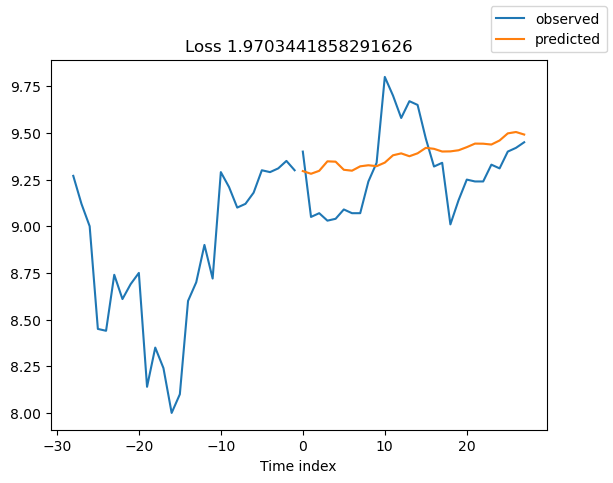

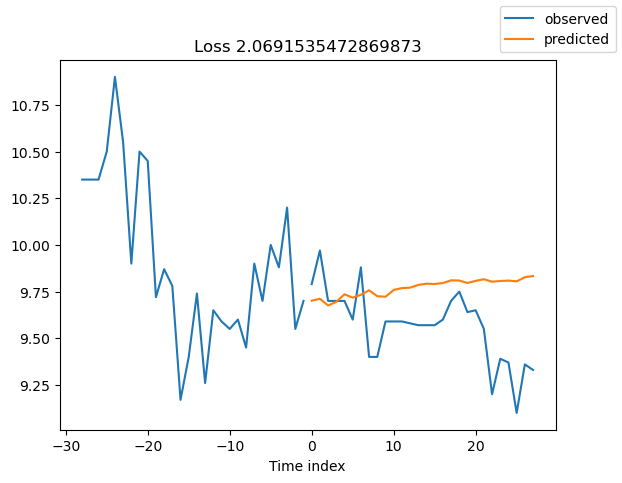

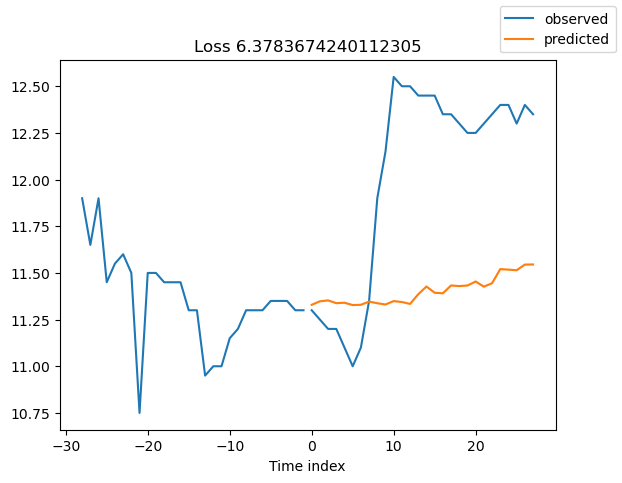

In [33]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

raw_predictions, x = best_model.predict(test_dataloader, mode="raw", return_x=True)

for idx in range(3):  # plot 3 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

In [36]:
# torch.save(best_model, '../models/nbeats.pth')

import pickle
with open('../modelsnbeats.pkl', 'wb') as f_model:
    pickle.dump(best_model, f_model, protocol=pickle.HIGHEST_PROTOCOL)

AttributeError: Can't pickle local object 'TupleOutputMixIn.to_network_output.<locals>.Output'

In [ ]:
# modify the "return_lstm_predictions" function from Milestone 1 and adapt it for N-BEATS
def return_nbeats_predictions(trainer, test_dataloader, test_df):
    """
    Given the trained trainer, test_dataloader and dataframe, 
    return a dataframe containing the actual and corresponding predicted values
    """
    # extract predictions from best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = NBeats.load_from_checkpoint(best_model_path)
    predictions, index = best_model.predict(test_dataloader, return_index=True)

    # merge predictions and actual data into single dataframe
    time_idx_start = index.loc[0, 'time_idx']
    time_idx_end = time_idx_start + len(predictions[0])
    predictions_df_wide = pd.DataFrame(predictions.numpy(), columns=range(time_idx_start, time_idx_end))
    predictions_df_wide['series_id'] = index['series_id']
    predictions_df = predictions_df_wide.melt(id_vars=['series_id'])
    predictions_df.rename(columns={'variable':'time_idx'}, inplace=True)
    nbeats_test_df = test_df.merge(predictions_df, on=['series_id', 'time_idx'])
    nbeats_test_df.rename(columns={'value': 'nbeats_pred'}, inplace=True)
    return nbeats_test_df